### Calculating transcripts per million and z-scores for dinoflagellated-filtered metatranscriptomic ORFs

This script reads in an annotated ORF file with taxonomy, maps read counts onto it, calculates transcripts per million for all ORFs, then filters for the top 50 most variant genes (from the Cohen et al. paper), calculates z-scores and plots the output as a heat map

In [8]:
import os
import glob
import pysam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
working_dir = '/vortexfs1/omics/env-bio/collaboration/dinoflagellates_METZYME/data/metaT_trimmed_reads/fasta_files/paired/mRNA/'

### Read in annotated ORF file with taxonomy

In [11]:
# Same TSV file generated in metaT_taxonomy.ipynb

dino_ORFs = 'diamond_output/dino_metzyme_annotated_coassembly_diamond_out_dinophyta.tsv'

df_dino = pd.read_csv(working_dir+dino_ORFs, sep='\t', header=0, index_col=0)

In [12]:
df_dino.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,taxonomy
227,NODE_26_length_11492_cov_18.457578_g19_i0_2_57...,Karenia-brevis-SP1-20130916|289615_1,33.7,1063,639,24,628,1654,3,1035,1.010000e-146,491.0,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dino...
231,NODE_14_length_13360_cov_26.370005_g9_i0_1698_...,Oxyrrhis-marina-20131105|151477_1,44.0,427,192,3,1,427,1,380,2.230000e-109,341.0,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dino...
301,NODE_42_length_9922_cov_24.243123_g4_i1_2_1073_-,Karenia-brevis-SP1-20130916|45901_1,65.8,342,113,2,20,357,93,434,1.080000e-159,464.0,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dino...
442,NODE_55_length_9298_cov_13.604855_g19_i1_2_4708_-,Karenia-brevis-SP1-20130916|289615_1,33.7,1063,639,24,267,1293,3,1035,8.550000e-149,491.0,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dino...
449,NODE_55_length_9298_cov_13.604855_g19_i1_4759_...,Karenia-brevis-SP1-20130916|289615_1,33.7,1063,639,24,211,1237,3,1035,3.320000e-149,491.0,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dino...


### Read in output of BWA mem (mapping reads to ORFs)

In [13]:
#Start with a test example on just the sample at 40m depth

sam_path = 'bwa_mem_nucleotide_files/30B8Z_S11_001_40m_mRNA_mapped_sorted.bam'

#Use pysam to open the .bam file
samfile = pysam.AlignmentFile(working_dir+sam_path, "rb")

In [14]:
#index statistics -- gives us the number of reads mapped to each contig
idx_stats = samfile.get_index_statistics()
print(idx_stats[0])

IndexStats(contig='NODE_1_length_22561_cov_36.839973_g0_i0_72_1721_-', mapped=6, unmapped=0, total=6)


In [15]:
contigs = []
mapped = []
unmapped = []

#"Unravel" list of index stats into individual lists of contig name, number of mapped and unmapped reads
for contig_stat in idx_stats:
    contigs.append(contig_stat.contig)
    mapped.append(contig_stat.mapped)
    unmapped.append(contig_stat.unmapped)

In [16]:
#Generate a dataframe from the index statistics
ORF_read_counts = pd.DataFrame({'contig': contigs, 'mapped': mapped, 'unmapped': unmapped})

#Ignore all contigs with no mapping hits
ORF_read_counts = ORF_read_counts[ORF_read_counts['mapped'] != 0]

In [17]:
# Join just dinoflagellates ORFs with all ORFs wth a read count of at least 1
dino_ORF_reads = ORF_read_counts.join(df_dino.set_index('qseqid'), on='contig', how='inner')

#Get reference length from BAM file
dino_ORF_reads['reference_length'] = dino_ORF_reads['contig'].map(lambda x: samfile.get_reference_length(x))

### TPM calculation

Defined as $TPM = \frac{x_i}{l_i} \times \frac{1}{\sum\limits_{n}{\frac{x_n}{l_n}}} \times 10^6$

First, we want to sum over all of the read counts normalized by contig length. Assigning that to `sum_x_over_l`, we can then multiply it by each read count normalized by contig length to get the transcripts per million used by Cohen et al. 

In [18]:
sum_x_over_l = pd.DataFrame(dino_ORF_reads['mapped']/dino_ORF_reads['reference_length']).sum(axis=0).values[0]

In [19]:
dino_ORF_reads['TPM'] = dino_ORF_reads['mapped']/dino_ORF_reads['reference_length']*(1/sum_x_over_l)*10**6

In [20]:
dino_ORF_reads[['contig', 'sseqid', 'TPM']]

,contig,sseqid,TPM
241,NODE_26_length_11492_cov_18.457578_g19_i0_2_57...,Karenia-brevis-SP1-20130916|289615_1,19.788548
321,NODE_42_length_9922_cov_24.243123_g4_i1_2_1073_-,Karenia-brevis-SP1-20130916|45901_1,3.176910
470,NODE_55_length_9298_cov_13.604855_g19_i1_2_4708_-,Karenia-brevis-SP1-20130916|289615_1,8.630657
478,NODE_55_length_9298_cov_13.604855_g19_i1_4759_...,Karenia-brevis-SP1-20130916|289615_1,9.861188
490,NODE_51_length_9419_cov_15.559050_g34_i1_107_9...,Karenia-brevis-CCMP2229-20130916|270247_1,39.002140
...,...,...,...
2161693,NODE_1961248_length_86_cov_2.006369_g1954686_i...,MMETSP0796-20121207|30551_1,9.009648
2161878,NODE_1961696_length_80_cov_2.476821_g1955134_i...,MMETSP0784-20121206|7079_1,15.593622
2162074,NODE_1962484_length_71_cov_2.323944_g1955922_i...,Durinskia-baltica-CSIRO_CS-38-20140214|100697_1,7.051029
2162099,NODE_1962392_length_72_cov_2.405594_g1955830_i...,Karlodinium-micrum-CCMP2283-20140214|26356_1,7.051029


In [22]:
dino_ORF_reads.sort_values(by='TPM', ascending=False)

,contig,mapped,unmapped,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,taxonomy,reference_length,TPM
222031,NODE_143768_length_655_cov_670.049658_g137723_...,1789,0,at05685-at,57.7,201,85,0,2,202,6,206,6.380000e-66,216.0,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dino...,609,714.602683
32401,NODE_14066_length_1337_cov_805.969984_g4441_i3...,483,0,Symbiodinium-sp-CCMP2430-20130923|104772_1,100.0,55,0,0,1,55,1,55,1.180000e-30,108.0,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dino...,165,712.089827
140229,NODE_82534_length_781_cov_367.628169_g77357_i0...,1122,0,Symbiodinium-sp-C1-20140214|25803_1,91.8,257,21,0,1,257,88,344,7.740000e-181,507.0,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dino...,774,352.633438
233168,NODE_152913_length_642_cov_711.809107_g146803_...,925,0,Symbiodinium-sp-C1-20140214|25803_1,93.0,213,15,0,1,213,1,213,6.690000e-147,419.0,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dino...,639,352.137656
1186533,NODE_996022_length_311_cov_541.416667_g989460_...,394,0,at05419-at,93.2,103,7,0,1,103,14,116,6.120000e-66,202.0,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dino...,309,310.176818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14230,NODE_5127_length_1882_cov_4.823302_g4211_i0_48...,1,0,Symbiodinium-sp-C15-20130923|7961_1,90.1,609,60,0,3,611,2,610,0.000000e+00,1084.0,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dino...,1833,0.132712
13629,NODE_4558_length_1969_cov_4.565332_g3730_i0_3_...,1,0,MMETSP0795-20121207|7901_1,71.6,570,161,1,1,570,57,625,5.600000e-292,816.0,Eukaryota;Alveolata;Dinophyta;Syndiniales;Dino...,1896,0.128302
1222,NODE_183_length_6100_cov_9.477691_g126_i0_1591...,2,0,MMETSP0253-20130528|72244_1,30.2,1587,980,42,4,1493,281,1836,1.580000e-185,608.0,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dino...,4509,0.107900
1678,NODE_271_length_5332_cov_6.018628_g194_i0_103_...,1,0,MMETSP0795-20121207|5263_1,52.6,832,364,11,10,828,8,822,2.080000e-291,830.0,Eukaryota;Alveolata;Dinophyta;Syndiniales;Dino...,2487,0.097813


### Full script below to process each sample and merge into one dataframe

In [23]:
sam_paths = ['bwa_mem_nucleotide_files/30B8Z_S11_001_40m_mRNA_mapped_sorted.bam', 
             'bwa_mem_nucleotide_files/30B91_S28_001_380m_mRNA_mapped_sorted.bam',
            'bwa_mem_nucleotide_files/30B90_S12_001_70m_mRNA_mapped_sorted.bam']

In [24]:
i=0

for path in sam_paths:
    samfile = pysam.AlignmentFile(working_dir+path, "rb")
    sample_id = path.split('/')[1].split('_mRNA')[0]
    
    idx_stats = samfile.get_index_statistics()
    
    contigs = []
    mapped = []
    unmapped = []

    for contig_stat in idx_stats:
        contigs.append(contig_stat.contig)
        mapped.append(contig_stat.mapped)
        unmapped.append(contig_stat.unmapped)
        
    ORF_read_counts = pd.DataFrame({'contig': contigs, 'mapped': mapped, 'unmapped': unmapped})

    #Ignore all contigs with no mapping hits
    ORF_read_counts = ORF_read_counts[ORF_read_counts['mapped'] != 0]
    
    dino_ORF_reads = ORF_read_counts.join(df_dino.set_index('qseqid'), on='contig', how='inner')

    #Get reference length from BAM file
    dino_ORF_reads['reference_length'] = dino_ORF_reads['contig'].map(lambda x: samfile.get_reference_length(x))
    
    sum_x_over_l = pd.DataFrame(dino_ORF_reads['mapped']/dino_ORF_reads['reference_length']).sum(axis=0).values[0]
    
    dino_ORF_reads['TPM'] = dino_ORF_reads['mapped']/dino_ORF_reads['reference_length']*(1/sum_x_over_l)*10**6
    
    if i == 0:
        output_df = dino_ORF_reads[['contig', 'TPM']]
        output_df = output_df.rename({'TPM': 'TPM_'+ sample_id}, axis=1)
    else:
        output_df = output_df.join(dino_ORF_reads[['contig', 'TPM']].set_index('contig'), how='outer', on='contig')
    output_df = output_df.rename({'TPM': 'TPM_'+ sample_id}, axis=1)
    
    i+=1 

In [25]:
# Change NaNs to 0s for calculation
output_df[['TPM_30B8Z_S11_001_40m', 'TPM_30B91_S28_001_380m', 'TPM_30B90_S12_001_70m']] = output_df[['TPM_30B8Z_S11_001_40m', 'TPM_30B91_S28_001_380m', 'TPM_30B90_S12_001_70m']].fillna(0)

In [26]:
output_df.head()

,contig,TPM_30B8Z_S11_001_40m,TPM_30B91_S28_001_380m,TPM_30B90_S12_001_70m
241.0,NODE_26_length_11492_cov_18.457578_g19_i0_2_57...,19.788548,1.390007,1.850755
321.0,NODE_42_length_9922_cov_24.243123_g4_i1_2_1073_-,3.176910,9.333768,5.880087
470.0,NODE_55_length_9298_cov_13.604855_g19_i1_2_4708_-,8.630657,1.524978,1.707436
478.0,NODE_55_length_9298_cov_13.604855_g19_i1_4759_...,9.861188,0.910516,1.319295
490.0,NODE_51_length_9419_cov_15.559050_g34_i1_107_9...,39.002140,3.153441,3.198434


### Bringing in the KEGG annotation data for making Figure 3

In [27]:
kegg_file = '/vortexfs1/omics/env-bio/collaboration/dinoflagellates_METZYME/data/metaT_trimmed_reads/fasta_files/paired/mRNA/KEGG_annotation/' \
            'dino_metzyme_annotated_coassembly_KEGG_annotation.txt'

In [28]:
top_50_genes = '/vortexfs1/omics/env-bio/collaboration/dinoflagellates_METZYME/data/metaT_trimmed_reads/fasta_files/paired/mRNA/KEGG_annotation/' \
            'top_50_kegg_genes.txt'
file = open(top_50_genes, 'r')
top_KOs = file.read().splitlines()

In [29]:
columns = ['Query', 'KO']
kegg_df = pd.read_csv(kegg_file, sep='\t', names=columns)

### Need to incorporate KOG and Pfam annotations

In [30]:
hmmer_dir = '/vortexfs1/omics/env-bio/collaboration/dinoflagellates_METZYME/data/metaT_trimmed_reads/fasta_files/paired/mRNA/hmmer_output/'
kog_file = hmmer_dir + 'dino_metzyme_annotated_coassembly_KOG2348_out'

In [31]:
ISIP2A_file = hmmer_dir + 'dino_metzyme_annotated_coassembly_low_iron_inducible_periplasmic_protein_out'
ISIP3_file = hmmer_dir + 'dino_metzyme_annotated_coassembly_iron_storage_protein_out'
PF01036_file = hmmer_dir + 'dino_metzyme_annotated_coassembly_proteorhodopsin_out'

In [32]:
# These should be the same for all hmmer output -- first rows are just metadata, 
# and then skipping the row that just has dashes to separate the header from the data

skip_rows_list = [i for i in range(14)]
skip_rows_list += [15]

#Requires some manual analysis to identify where the relevant rows end, because it depends on the e-value
#we chose and how many fall below that. Would be nice to automate this if possible

KOG_2348 = pd.read_csv(kog_file, sep='\s+', skiprows=skip_rows_list, nrows=248)

In [33]:
skip_rows_list = [i for i in range(13)]
skip_rows_list += [14]

ISIP2A = pd.read_csv(ISIP2A_file, sep='\s+', skiprows=skip_rows_list, nrows=343)

In [34]:
skip_rows_list = [i for i in range(13)]
skip_rows_list += [14]

ISIP3 = pd.read_csv(ISIP3_file, sep='\s+', skiprows=skip_rows_list, nrows=45)

In [35]:
isip3_df = ISIP3[['Sequence']]
isip3_df['function'] = 'ISIP_3'

/tmp/ipykernel_235383/1843089003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isip3_df['function'] = 'ISIP_3'


In [36]:
skip_rows_list = [i for i in range(13)]
skip_rows_list += [14]

PF01036 = pd.read_csv(PF01036_file, sep='\s+', skiprows=skip_rows_list, nrows=1140)

In [37]:
kog_df = KOG_2348[['Sequence']]
kog_df['function'] = 'KOG2348'

proteorhodopsin_df = PF01036[['Sequence']]
proteorhodopsin_df['function'] = 'PF01036'

isip2a_df = ISIP2A[['Sequence']]
isip2a_df['function'] = 'pti:PHATRDRAFT_54465'

isip3_df = ISIP3[['Sequence']]
isip3_df['function'] = 'pti:PHATRDRAFT_47674'

added_function_df = pd.concat([kog_df, proteorhodopsin_df ,isip2a_df, isip3_df])

/tmp/ipykernel_235383/1520715355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kog_df['function'] = 'KOG2348'
/tmp/ipykernel_235383/1520715355.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proteorhodopsin_df['function'] = 'PF01036'
/tmp/ipykernel_235383/1520715355.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [38]:
#Joining both taxonomy and functional annotation in the same dataframe

tax_func_df = output_df.join(kegg_df.set_index('Query'), on='contig', how='left')
tax_func_df = tax_func_df.join(added_function_df.set_index('Sequence'), on='contig', how='left')

tax_func_df = tax_func_df.reset_index(drop=True)

In [39]:
ko_summed = tax_func_df[tax_func_df['KO'].isin(top_KOs)].groupby('KO').sum()
ko_summed.reset_index(inplace=True)
ko_summed = ko_summed.rename({'KO': 'functional_annotation'}, axis=1)

In [40]:
other_func_summed = tax_func_df[~tax_func_df['function'].isnull()].groupby('function').sum()
other_func_summed.reset_index(inplace=True)
other_func_summed = other_func_summed.rename({'function': 'functional_annotation'}, axis=1)

In [41]:
top_50_df = pd.concat([ko_summed, other_func_summed])
top_50_df = top_50_df.set_index('functional_annotation')

In [42]:
# Figure out if any genes in Cohen et al's top 50 list were not identified with KEGG, KOG or Pfam annotations
missing_KOs = np.array(top_KOs)[~np.array([KO in top_50_df.index for KO in top_KOs])]

missing_dict = {}
missing_dict['functional_assignment'] = missing_KOs
for col in top_50_df.columns:
    missing_dict[col] = np.repeat(np.nan, len(missing_KOs))
    
top_50_df = pd.concat([top_50_df, pd.DataFrame(missing_dict).set_index('functional_assignment')])

#Sort according to same list as in original paper
top_50_df = top_50_df.loc[top_KOs]

In [43]:
top_50_df_log_norm = top_50_df[['TPM_30B8Z_S11_001_40m', 'TPM_30B91_S28_001_380m', 
                                'TPM_30B90_S12_001_70m']].apply(lambda x: np.log2(x + 1))

n = top_50_df_log_norm.shape[0]

In [44]:
z_score_40 = (top_50_df_log_norm['TPM_30B8Z_S11_001_40m'] - 
              top_50_df_log_norm.mean(axis=1))/(top_50_df_log_norm.std(axis=1))
z_score_70 = (top_50_df_log_norm['TPM_30B90_S12_001_70m'] - 
              top_50_df_log_norm.mean(axis=1))/(top_50_df_log_norm.std(axis=1))
z_score_380 = (top_50_df_log_norm['TPM_30B91_S28_001_380m'] - 
               top_50_df_log_norm.mean(axis=1))/(top_50_df_log_norm.std(axis=1))


In [45]:
test1 = np.concatenate([z_score_40.values.reshape(n, 1), z_score_70.values.reshape(n, 1), z_score_380.values.reshape(n, 1)], axis=1)

In [46]:
# test1 = np.concatenate([((np.log2(ko_summed['TPM_30B8Z_S11_001_40m'].values + 1) - 
#                          np.log2(ko_summed.mean(axis=1).values))/(np.log2(ko_summed.std(axis=1).values))).reshape((n, 1)),
#                        ((np.log2(ko_summed['TPM_30B90_S12_001_70m'].values + 1) - 
#                          np.log2(ko_summed.mean(axis=1).values))/(np.log2(ko_summed.std(axis=1).values))).reshape((n, 1)), 
#                        ((np.log2(ko_summed['TPM_30B91_S28_001_380m'].values + 1) - 
#                          np.log2(ko_summed.mean(axis=1).values))/(np.log2(ko_summed.std(axis=1).values))).reshape((n, 1))], axis=1)


In [47]:
labels = top_KOs

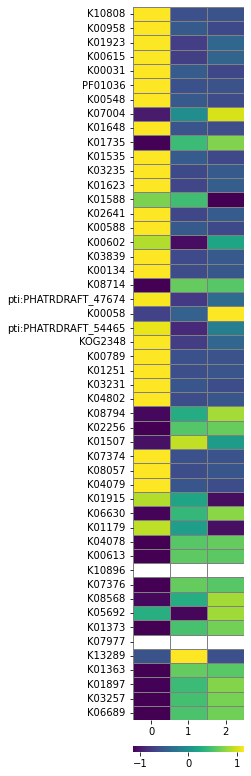

In [48]:
fig, ax = plt.subplots(figsize = (2, 16))
cb = sns.heatmap(test1, linecolor='gray', linewidth=0.5, cmap='viridis', yticklabels=labels, 
                 cbar_kws={"orientation": "horizontal", "pad": 0.03})
#ax.yaxis.set(ticks=np.arange(0.5, len(labels)), ticklabels=labels);

### Want to add functional annotations in addition to the gene names

In [49]:
kegg_dir = '/vortexfs1/omics/env-bio/collaboration/dinoflagellates_METZYME/databases/KEGG/'
ko_txt = 'ko_list'

In [50]:
ko_list_df = pd.read_csv(kegg_dir + ko_txt, sep='\t')
ko_list_df = ko_list_df.set_index('knum')
ko_list_df = ko_list_df[['definition']]

In [51]:
# Get proteins in top 50 list that don't have KEGG annotations (i.e., because they are not from the KEGG database)
missing_annot = np.array(top_KOs)[~np.array([KO in ko_list_df.index for KO in top_KOs])]
present_annot = np.array(top_KOs)[np.array([KO in ko_list_df.index for KO in top_KOs])]

In [52]:
top_annot = ko_list_df.loc[present_annot]
top_annot = top_annot['definition'].str.split('[', expand=True)[[0]]
top_annot = top_annot.rename({0: 'definition'}, axis=1)

In [53]:
## Manually adding in the missing annotations, because they were also done that way in the original paper
print(missing_annot)
annot_dict = {'name': missing_annot, 'definition': ['proteorhodopsin', 'ISIP3', 
                                                    'ISIP2A', 'Urea transporter', 'Arf/Sar family, other']}
top_annot = pd.concat([top_annot, pd.DataFrame(annot_dict).set_index('name')])
top_annot = top_annot.loc[top_KOs]
labels = (top_annot['definition'].str.capitalize() +' (' + top_annot.index + ')').values

['PF01036' 'pti:PHATRDRAFT_47674' 'pti:PHATRDRAFT_54465' 'KOG2348'
 'K07977']


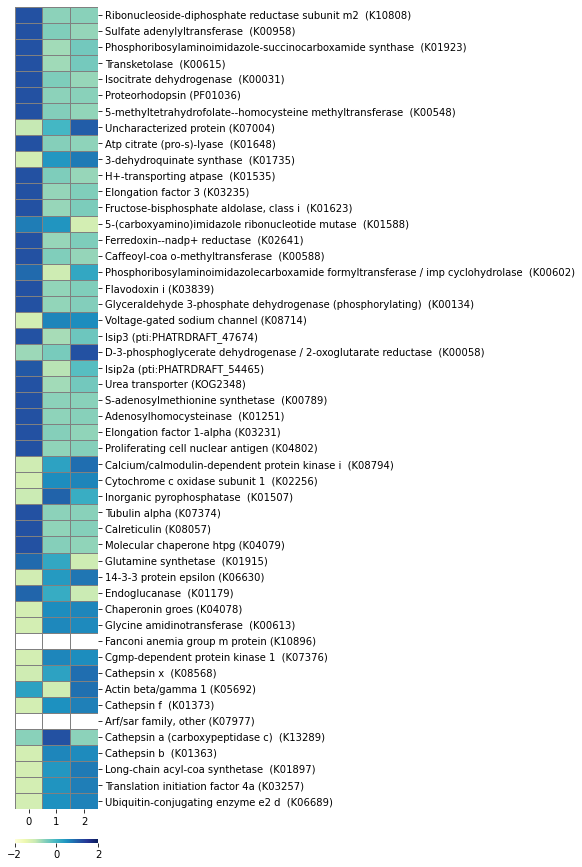

In [54]:
fig, ax = plt.subplots(figsize = (1.5, 18))

custom_palette = sns.color_palette("YlGnBu", 9)

cb = sns.heatmap(test1, linecolor='gray', linewidth=0.5, cmap="YlGnBu", vmin=-2, vmax=2, yticklabels=labels, 
                 cbar_kws={"orientation": "horizontal", "pad": 0.03})


ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.tick_params(axis='y', rotation=0)

#ax.yaxis.set(ticks=np.arange(0.5, len(labels)), ticklabels=labels);